In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import pytorch_lightning as pl

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

torch.set_float32_matmul_precision('medium')
pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

In [3]:
num_train, num_test = 10000, 2000
feature_dim = 10
z_gap = 1.
y_gap = 3.

def generate_data(num_data, feature_dim, z_gap, y_gap):
    # Latent confounder z is binary.
    z = dist.Bernoulli(0.5).sample([num_data])

    # Covariates x are normally distributed, with higher variance for z=1.
    x = dist.Normal(z * z_gap, 5 * z + 3 * (1 - z)).sample([feature_dim]).t()

    # Treatment t is binary, with higher probability for z=1.
    t = dist.Bernoulli(0.75 * z + 0.25 * (1 - z)).sample()

    # Outcome y is binary, with higher probability for z=1 and t=1.
    y = dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))).sample()

    # Compute true c-specific CATE for evaluation.
    t0_t1 = torch.tensor([[0.0], [1.0]])
    y_t0, y_t1 = dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t0_t1 - 1))).mean
    true_cates = y_t1 - y_t0
    return x, t, y, z, true_cates

# Note: In the CEVAE paper they refer to c-specific causal effects as individual treatment effects.
# We use the term c-specific causal effects to be consistent with the terminology in the broader causal inference literature.
# with torch.no_grad():
x_train, t_train, y_train, _, _ = generate_data(num_train, feature_dim, z_gap, y_gap)
x_test, _, _, z_test, true_cates = generate_data(num_test, feature_dim, z_gap, y_gap)

In [4]:
class FullyConnected(nn.Sequential):
    # Fully connected neural network with ELU activations.
    def __init__(self, sizes):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        super().__init__(*layers)


class DiagNormalNet(FullyConnected):
    # Fully connected neural network with ELU activations, followed by a diagonal Gaussian.
    def __init__(self, sizes):
        assert len(sizes) >= 2
        sizes = sizes[:-1] + [sizes[-1] * 2]
        super().__init__(sizes)

    def forward(self, x):
        loc, scale = super().forward(x).chunk(2, dim=-1)
        return loc, nn.functional.softplus(scale)


class BernoulliNet(FullyConnected):
    # Fully connected neural network with ELU activations, followed by a Bernoulli.
    def __init__(self, sizes):
        super().__init__(sizes + [1])

    def forward(self, x):
        return super().forward(x).squeeze(-1).clamp(min=-10, max=10)


class PreWhitener(nn.Module):
    """
    Data pre-whitener.
    """
    def __init__(self, data):
        super().__init__()
        with torch.no_grad():
            loc = data.mean(0)
            scale = data.std(0)
            scale[~(scale > 0)] = 1.0
            self.register_buffer("loc", loc)
            self.register_buffer("inv_scale", scale.reciprocal())

    def forward(self, data):
        return (data - self.loc) * self.inv_scale

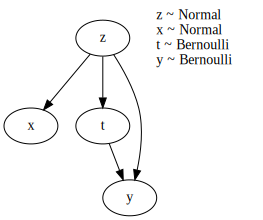

In [5]:
class ProxyConfounderModel(PyroModule):
    """
    :param dict config: A dict specifying ``feature_dim``, ``latent_dim``,
        ``hidden_dim``, ``num_layers``, and ``outcome_dist``.
    """

    def __init__(self, feature_dim: int, latent_dim: int, hidden_dim: int, num_layers: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.feature_dim = feature_dim
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))
        self.x_nn = DiagNormalNet([latent_dim] + [hidden_dim] * num_layers + [feature_dim])
        self.t_nn = BernoulliNet([latent_dim])
        # The y network is split between the two t values.
        self.y0_nn = BernoulliNet([latent_dim] + [hidden_dim] * num_layers)
        self.y1_nn = BernoulliNet([latent_dim] + [hidden_dim] * num_layers)

    def forward(self):
        # Proxy confounder
        z = pyro.sample("z", dist.Normal(self.zero, self.one).expand([self.latent_dim]).to_event(1))
        # Observed covariates
        x = pyro.sample("x", dist.Normal(*self.x_nn(z)).to_event(1))
        # Treatment
        t = pyro.sample("t", dist.Bernoulli(logits=self.t_nn(z)))
        # parameters are not shared among values of t
        y_logits = torch.where(t == 1, self.y1_nn(z), self.y0_nn(z))
        # Outcome
        y = pyro.sample("y", dist.Bernoulli(logits=y_logits))
        return y


individual_model = ProxyConfounderModel(
    feature_dim=x_train.shape[-1],
    latent_dim=5,
    hidden_dim=200,
    num_layers=3,
)
pyro.render_model(individual_model, render_distributions=True)

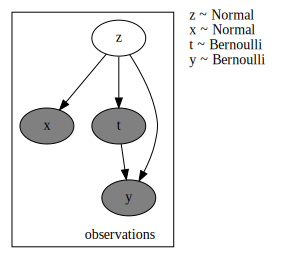

In [6]:
import pyro
from pyro.nn import PyroModule
from pyro import plate, condition


class CEVAE_Population(PyroModule):
    def __init__(self, individual_model):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_obs, t_obs, y_obs):
        # Create a dictionary of observed data
        conditioned_data = {"x": x_obs, "t": t_obs, "y": y_obs}

        # Use pyro.condition to condition the model on observed data
        conditioned_model = pyro.condition(self.individual_model, data=conditioned_data)

        # Use a plate to indicate conditionally independent observations
        with plate("observations", size=x_obs.shape[0], dim=-1):
            return conditioned_model()


# Create an instance of the model and render it
mle_model = CEVAE_Population(individual_model)
pyro.render_model(mle_model, model_args=(x_train, t_train, y_train), render_distributions=True)


In [7]:
class LightningSVI(pl.LightningModule):
    def __init__(self, elbo: pyro.infer.elbo.ELBOModule, **optim_params):
        super().__init__()
        self.optim_params = dict(optim_params)
        self.elbo = elbo

    def configure_optimizers(self):
        return torch.optim.Adam(self.elbo.parameters(), **self.optim_params)

    def training_step(self, batch, batch_idx):
        return self.elbo(*batch)

# elbo and guide
mle_guide = pyro.infer.autoguide.AutoNormal(mle_model)
elbo = pyro.infer.Trace_ELBO()(mle_model, mle_guide)

# initialize parameters
elbo(x_train, t_train, y_train)

# data
train_dataset = torch.utils.data.TensorDataset(x_train, t_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=x_train.shape[0])

# fit parameters
svi = LightningSVI(elbo, lr=1e-3, weight_decay=1e-4)
trainer = pl.Trainer(max_epochs=2500, log_every_n_steps=1)
trainer.fit(svi, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/natkramarz/xai/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | elbo | ELBOModule | 349 K  | train
--------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397     Total estimated model params size (MB)
32        Modules in train mode
0         Modules 

Epoch 2499: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=2500` reached.


Epoch 2499: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=1]


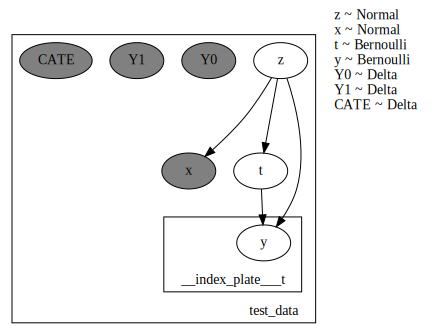

In [8]:
class CEVAE_CATE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    @pyro.infer.config_enumerate
    def forward(self, x_pred):
        # As we're evaluating the CATE, we need to condition on the observed data at test time.
        with MultiWorldCounterfactual(), \
                do(actions=dict(t=(0., 1.))), \
                condition(data=dict(x=x_pred)), \
                pyro.plate("test_data", size=x_pred.shape[0], dim=-1):

            Ys_pred = self.individual_model()
            Y0 = pyro.deterministic("Y0", gather(Ys_pred, IndexSet(t={1})), event_dim=0)
            Y1 = pyro.deterministic("Y1", gather(Ys_pred, IndexSet(t={2})), event_dim=0)
            return pyro.deterministic("CATE", Y1 - Y0, event_dim=0)


cate_model = CEVAE_CATE(individual_model)
pyro.render_model(cate_model, model_args=(x_train,), render_distributions=True)
